# importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , RMSprop , Adagrad , Adamax , SGD
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D ,Input, Lambda, ZeroPadding2D
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from glob import glob
from tensorflow.keras.regularizers import l2 , l1
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns
import matplotlib.image as img
from IPython.display import Image as IPyImage
from PIL import Image
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, 
recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve,
plot_precision_recall_curve, average_precision_score)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils 
from sklearn.model_selection import train_test_split
from numpy import interp
from tensorflow.keras.layers import InputLayer , TimeDistributed, LSTM
from tensorflow.keras import layers

# Loading dataset

## Defining a fuction for loading images ... 

In [2]:
IMM_SIZE = 64

In [3]:
def load_data(folder):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')] # ctreate a list of SubFolders

    data = []
    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(folder + "/" + f + "/*")
        print("loading: ", f)
        fig = plt.figure(figsize = (50,50)) 
        for im_n, im in enumerate(images):
            plt.gray() 
            image = cv2.imread(im)
            if len(image.shape) > 2:
                image = cv2.resize(image, (IMM_SIZE, IMM_SIZE), interpolation = cv2.INTER_LINEAR) 
            else:
                image = cv2.resize(image, (IMM_SIZE, IMM_SIZE))
            if len(image.shape) > 2:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image.flatten()
                                           
            data.append([image, f])
        

    return np.array(data) 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir_data='/content/drive/MyDrive/Data'
data = load_data(dir_data)

['squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'normal', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa']
loading:  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
loading:  normal
loading:  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
loading:  large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


<ipython-input-3-051b54bfa45f>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

# Preprocessing

## Segregation between images and labels 

In [6]:
images = []
labels = []


for feature, label in data:
    images.append(feature)
    labels.append(label)

#min_max normalization
images = np.array(images) / 255.0

# Resizing input images
images = images.reshape(-1, IMM_SIZE, IMM_SIZE, 1)

# Creating a dictionary of clases
lab = {}
for i, l in enumerate(set(labels)):
    lab[l] = i


labels = np.array([lab[l] for l in labels])

In [7]:
print("Shape of the input DataSet:", images.shape)
print("Shape of the output DataSet:", labels.shape)
print("Dictionary of classes:", lab)

Shape of the input DataSet: (1000, 64, 64, 1)
Shape of the output DataSet: (1000,)
Dictionary of classes: {'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 0, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 1, 'normal': 2, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 3}


## Encoding labels

In [8]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
dummy_Y = np_utils.to_categorical(encoded_Y)
dummy_Y.astype(int)

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

## Train_Test_Validation Split 

In [9]:
train_dataset, test_dataset, train_label, test_label = train_test_split(images, dummy_Y, test_size = .3)

In [10]:
test_dataset, validation_dataset, test_label, validation_label = train_test_split(test_dataset, test_label, test_size = .3)

In [11]:
print('train_d :' , train_dataset.shape)
print('test_shape :' , test_dataset.shape)
print('validation_shape :' , validation_dataset.shape)

train_d : (700, 64, 64, 1)
test_shape : (210, 64, 64, 1)
validation_shape : (90, 64, 64, 1)


# Autoencoder_v1

In [12]:
batch_size = 18
epochs = 30
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))
num_classes = 4


In [13]:
def encoder(input_img):
    #encoder
    #input = 64 x 64 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #64 x 64 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded


In [14]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.optimizers import RMSprop

In [15]:
autoencoder_v1 = Model(input_img, decoder(encoder(input_img)))
autoencoder_v1.compile(loss='mean_squared_error', optimizer = RMSprop(),metrics='mae')


In [16]:
autoencoder_v1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0     

In [17]:
history_v1 = autoencoder_v1.fit(train_dataset, train_dataset, batch_size=batch_size,epochs=epochs,validation_data=(validation_dataset, validation_dataset))


Epoch 1/30
39/39 [==============================] - 80s 2s/step - loss: 0.0617 - mae: 0.1842 - val_loss: 0.0665 - val_mae: 0.2191
Epoch 2/30
39/39 [==============================] - 75s 2s/step - loss: 0.0278 - mae: 0.1211 - val_loss: 0.0585 - val_mae: 0.2055
Epoch 3/30
39/39 [==============================] - 75s 2s/step - loss: 0.0211 - mae: 0.1051 - val_loss: 0.0631 - val_mae: 0.2076
Epoch 4/30
39/39 [==============================] - 73s 2s/step - loss: 0.0170 - mae: 0.0920 - val_loss: 0.0543 - val_mae: 0.1977
Epoch 5/30
39/39 [==============================] - 71s 2s/step - loss: 0.0160 - mae: 0.0877 - val_loss: 0.0460 - val_mae: 0.1829
Epoch 6/30
39/39 [==============================] - 76s 2s/step - loss: 0.0142 - mae: 0.0843 - val_loss: 0.0417 - val_mae: 0.1749
Epoch 7/30
39/39 [==============================] - 72s 2s/step - loss: 0.0119 - mae: 0.0741 - val_loss: 0.0245 - val_mae: 0.1332
Epoch 8/30
39/39 [==============================] - 72s 2s/step - loss: 0.0118 - mae: 0.07

In [18]:
def tr_plot(tr_data, start_epoch,a,b):
    #Plot the training and validation data
    tacc=tr_data.history['mae']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_mae']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].set_ylim([a,b])
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training mae')
    axes[1].set_ylim([a,b])
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation mae')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation mae')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('mae', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    

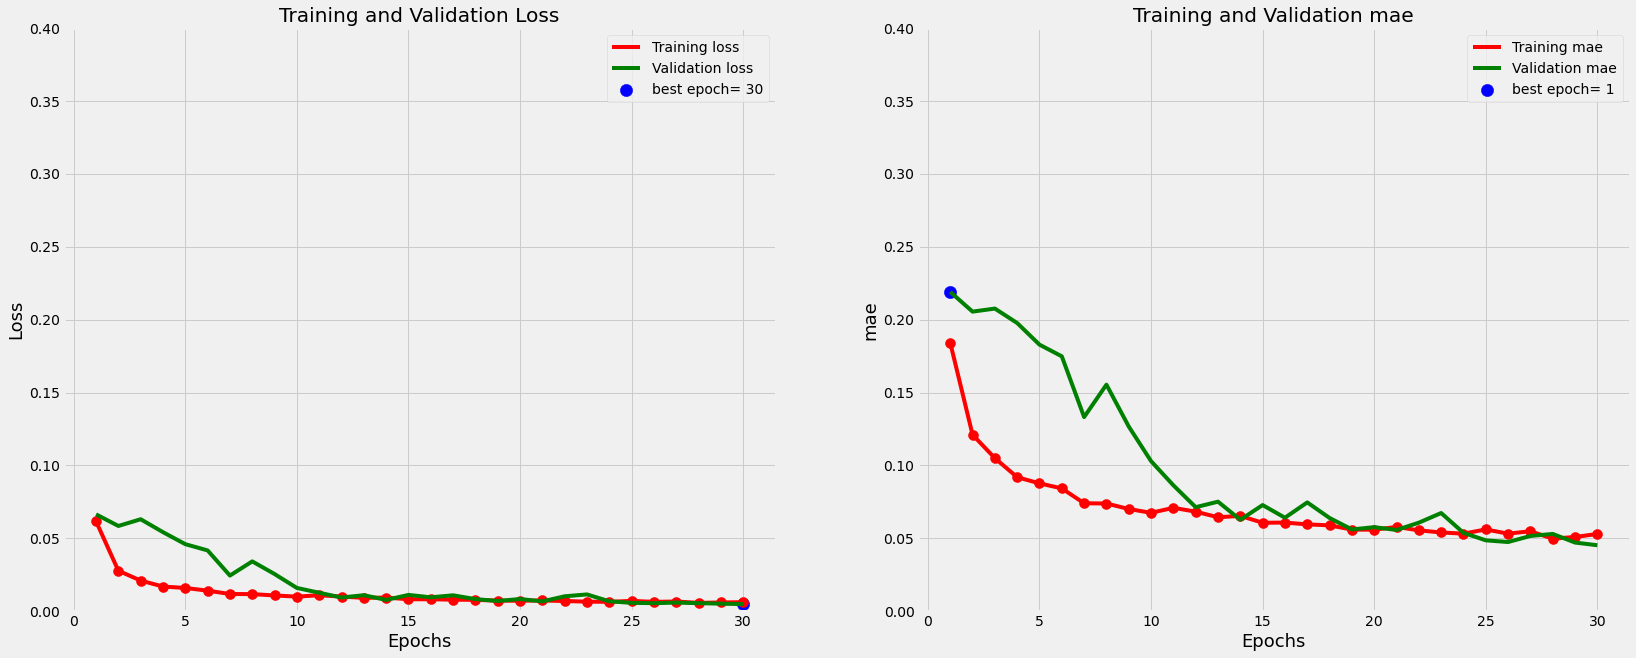

In [19]:
tr_plot(history_v1,0,0,0.4)

# Autoencoder_v2

In [ ]:
from tensorflow.keras import layers, losses


In [ ]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim  
    
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(4096, activation='sigmoid'),
      layers.Reshape((64, 64))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_v2 = Autoencoder(latent_dim)

In [ ]:
autoencoder_v2.compile(optimizer='adam', loss=losses.MeanSquaredError(),metrics='mae')

In [ ]:
history_v2 = autoencoder_v2.fit(train_dataset, train_dataset,
                batch_size=16,
                epochs=132,
                shuffle=True,
                validation_data=(validation_dataset, validation_dataset))

Epoch 1/132
44/44 [==============================] - 1s 11ms/step - loss: 0.0090 - mae: 0.0647 - val_loss: 0.0132 - val_mae: 0.0774
Epoch 2/132
44/44 [==============================] - 0s 8ms/step - loss: 0.0079 - mae: 0.0598 - val_loss: 0.0130 - val_mae: 0.0770
Epoch 3/132
44/44 [==============================] - 0s 8ms/step - loss: 0.0078 - mae: 0.0595 - val_loss: 0.0130 - val_mae: 0.0768
Epoch 4/132
44/44 [==============================] - 0s 7ms/step - loss: 0.0078 - mae: 0.0594 - val_loss: 0.0130 - val_mae: 0.0768
Epoch 5/132
44/44 [==============================] - 0s 8ms/step - loss: 0.0078 - mae: 0.0595 - val_loss: 0.0131 - val_mae: 0.0771
Epoch 6/132
44/44 [==============================] - 0s 7ms/step - loss: 0.0079 - mae: 0.0596 - val_loss: 0.0131 - val_mae: 0.0773
Epoch 7/132
44/44 [==============================] - 0s 7ms/step - loss: 0.0079 - mae: 0.0598 - val_loss: 0.0131 - val_mae: 0.0773
Epoch 8/132
44/44 [==============================] - 0s 8ms/step - loss: 0.0080 - 

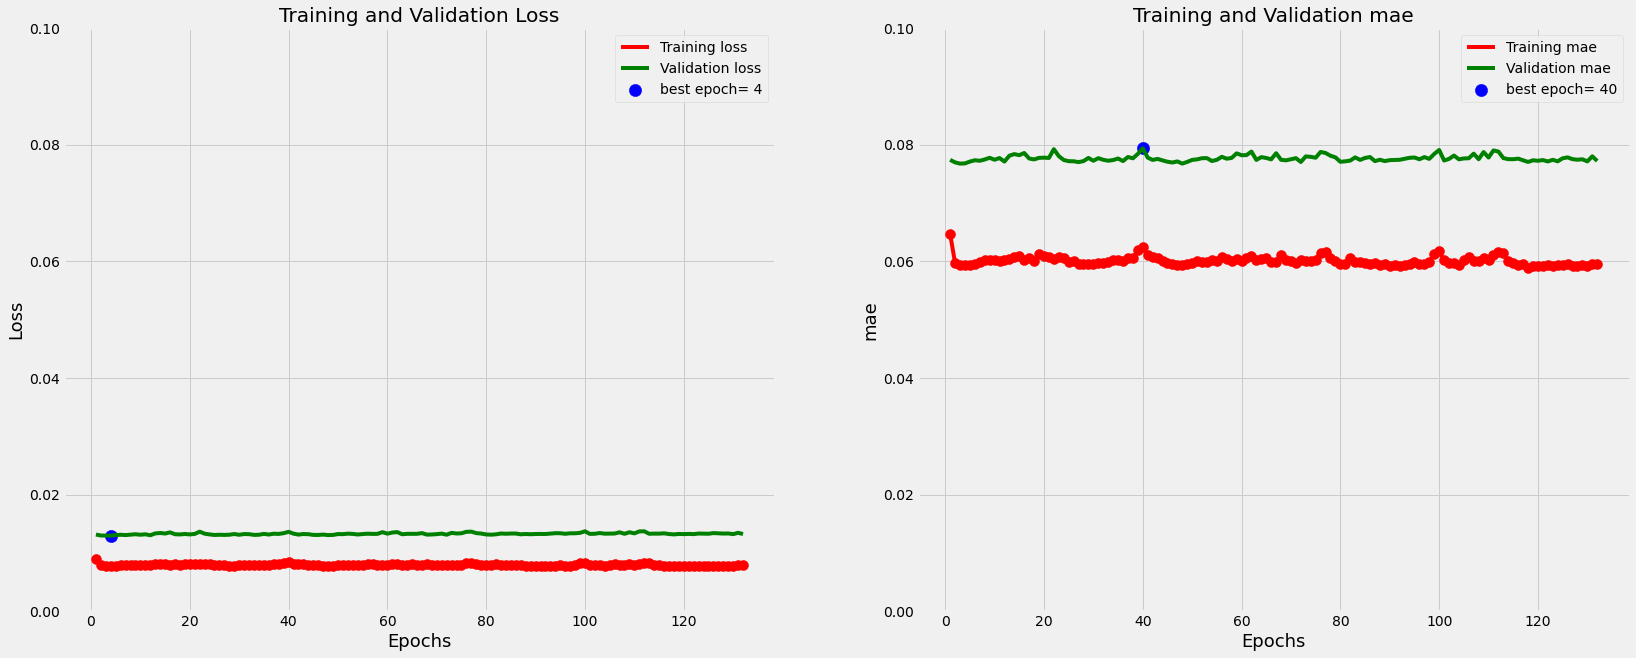

In [ ]:
tr_plot(history_v2,0,0,0.1)

In [ ]:
encoded_imgs = autoencoder_v2.encoder(test_dataset).numpy()
decoded_imgs = autoencoder_v2.decoder(encoded_imgs).numpy()

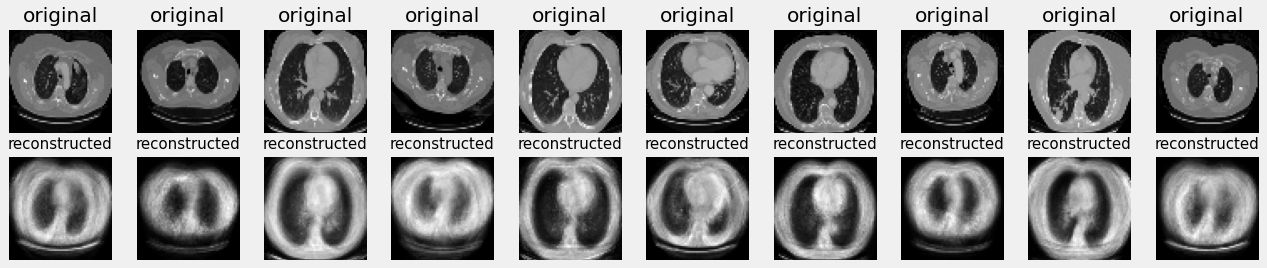

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.title("original")
  plt.imshow(tf.squeeze(test_dataset[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.title(label="reconstructed",fontsize =15)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Autoencoder_v3

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_v3 = Denoise()

In [ ]:
autoencoder_v3.compile(optimizer='adam', loss=losses.MeanSquaredError(),metrics='mae')

In [ ]:
autoencoder_v3.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 16)        160       
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 8)         1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder_v3.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_v3=autoencoder_v3.fit(train_dataset , train_dataset,
                epochs=50,
                shuffle=True,
                validation_data=(validation_dataset, validation_dataset))

Epoch 1/50
22/22 [==============================] - 5s 182ms/step - loss: 0.0109 - mae: 0.0709 - val_loss: 0.0102 - val_mae: 0.0668
Epoch 2/50
22/22 [==============================] - 4s 174ms/step - loss: 0.0100 - mae: 0.0661 - val_loss: 0.0100 - val_mae: 0.0667
Epoch 3/50
22/22 [==============================] - 4s 174ms/step - loss: 0.0097 - mae: 0.0645 - val_loss: 0.0097 - val_mae: 0.0641
Epoch 4/50
22/22 [==============================] - 4s 176ms/step - loss: 0.0094 - mae: 0.0633 - val_loss: 0.0094 - val_mae: 0.0632
Epoch 5/50
22/22 [==============================] - 4s 174ms/step - loss: 0.0092 - mae: 0.0621 - val_loss: 0.0092 - val_mae: 0.0623
Epoch 6/50
22/22 [==============================] - 4s 175ms/step - loss: 0.0089 - mae: 0.0611 - val_loss: 0.0089 - val_mae: 0.0611
Epoch 7/50
22/22 [==============================] - 4s 173ms/step - loss: 0.0087 - mae: 0.0601 - val_loss: 0.0087 - val_mae: 0.0608
Epoch 8/50
22/22 [==============================] - 4s 174ms/step - loss: 0.

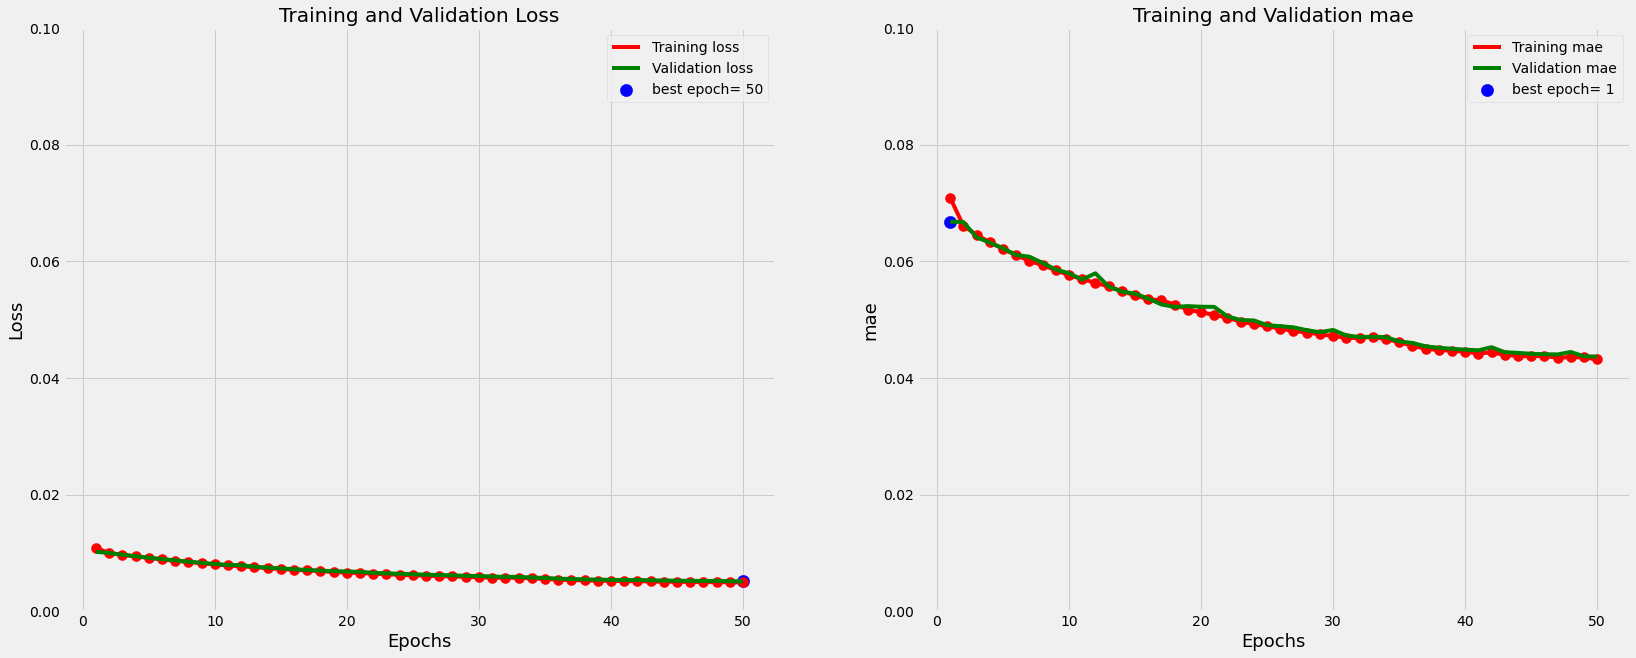

In [ ]:
tr_plot(history_v3,0,0,0.1)

In [ ]:
encoded_imgs = autoencoder_v3.encoder(test_dataset).numpy()
decoded_imgs = autoencoder_v3.decoder(encoded_imgs).numpy()

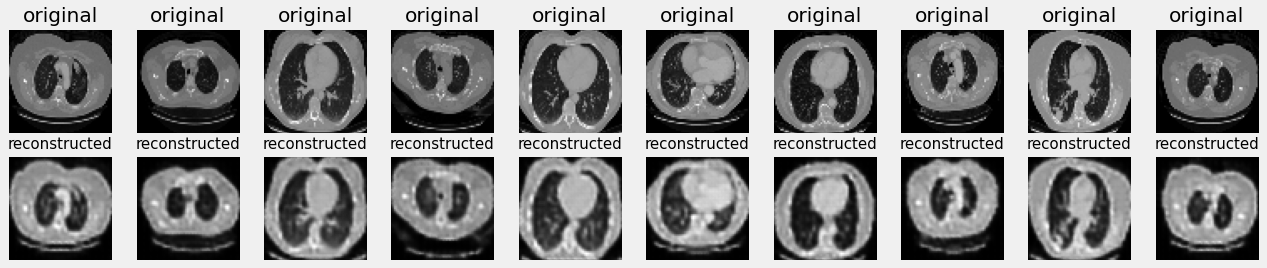

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(test_dataset[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title(label="reconstructed",fontsize =15)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()